## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.


# Import Library

In [1]:
import cv2
import time
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

# sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from skimage.feature import hog

from scipy.ndimage.measurements import label
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### debugLog

In [2]:
DEBUG = False

def debugLog(log):
    if DEBUG:
        print ( log )

# Load and Display Classify Image

In [3]:
def load_image(path):
    
    images = []
    files = []
    
    for fileName in glob.glob(path+'/*png'):
        image = cv2.imread(fileName)
        images.append(image)
        files.append(fileName)
        
    return np.array(images) #, np.array(files)

In [4]:
def load_classify_image():
    
    root = './classify_images/'
    nonVehicles = ['Extras', 'GTI']
    vehicles = ['GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right', 'KITTI_extracted']
    non_vehicle_images = []
    vehicle_images = []    
         
    non_vehicle_images = np.concatenate([load_image(root + 'non-vehicles/' + path)
                                                    for path in nonVehicles ], axis=0)
            
    vehicle_images =np.concatenate([load_image(root + 'vehicles/' + path)
                                                    for path in vehicles ], axis=0)  

    return vehicle_images, non_vehicle_images    

In [5]:
vehicle_images, non_vehicle_images = load_classify_image()

print("Vehicle Image Sample Read Loaded:         ", len(vehicle_images))
print("Non Vehicle Image Sample Read Loaded:  ", len(non_vehicle_images))

Vehicle Image Sample Read Loaded:          8792
Non Vehicle Image Sample Read Loaded:   8968


In [6]:
def printImage(row, colum, images, title):

    fig, axs = plt.subplots(row, colum, figsize=(17, 7))
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(hspace = .2, wspace=.05)
    axs = axs.ravel()

    for i in range(10):
        axs[i].axis('off')
        axs[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))

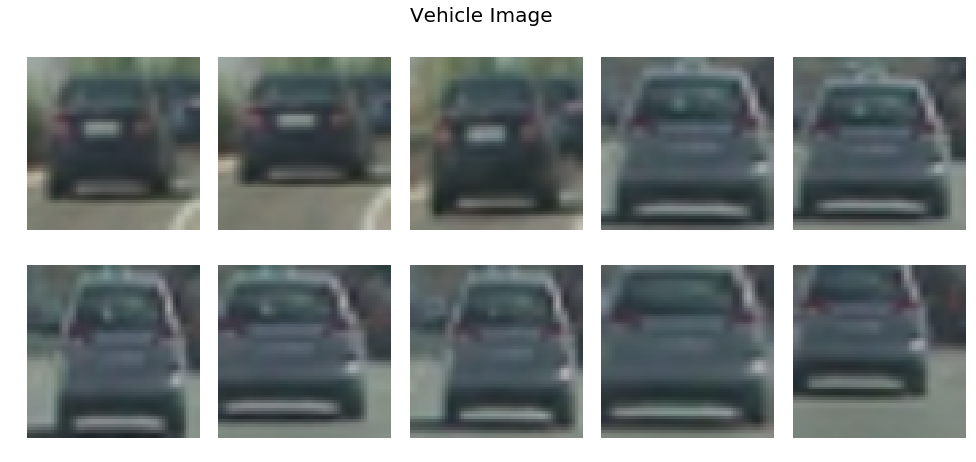

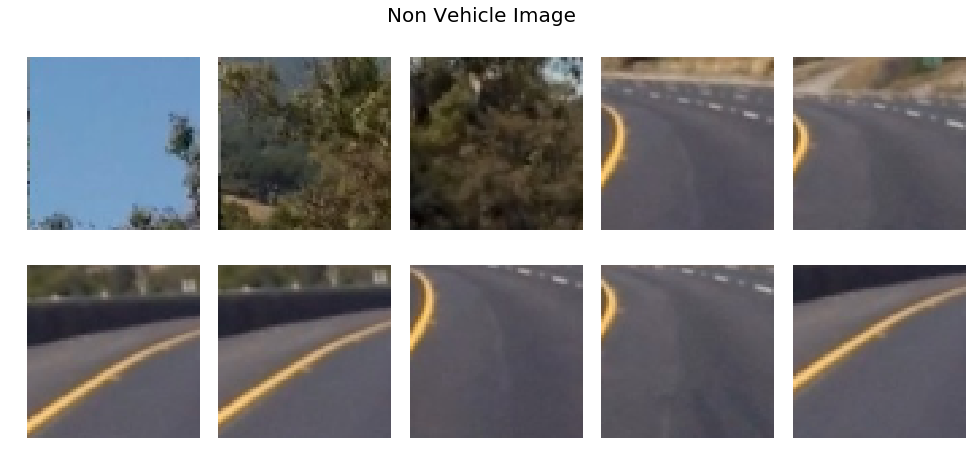

In [7]:
printImage(2, 5, vehicle_images, 'Vehicle Image')
printImage(2, 5, non_vehicle_images, 'Non Vehicle Image')

# Feature extraction
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

In [8]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [9]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [10]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

* Udacity Tip
* In one of the previous exercises you extracted HOG features from each individual window as you searched across the image, but it turns out this is rather inefficient. To speed things up, extract HOG features just once for the entire region of interest (i.e. lower half of each frame of video) and subsample that array for each sliding window.
* **To do this, apply skimage.feature.hog() with the flag feature_vec=False

In [11]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [12]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one
        # image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

* spatial_feat = False  # Spatial features on or off
* hist_feat = False  # Histogram features on or off 

In [13]:
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 16  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off 
hog_feat = True # HOG features on or off

t=time.time()

car_features = extract_features(vehicle_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_vehicle_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

144.43 Seconds to extract HOG features...


In [14]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 16 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 12576


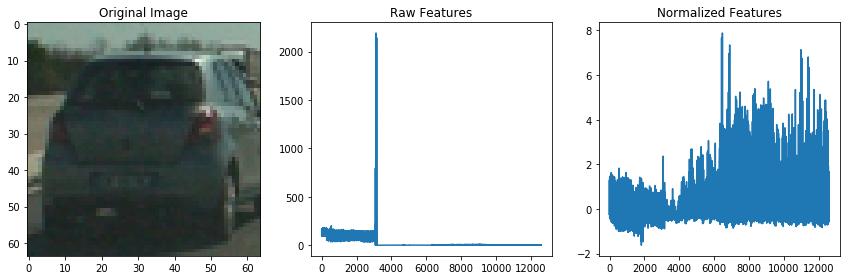

In [15]:
car_random = np.random.randint(0, len(vehicle_images))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(vehicle_images[car_random], cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_random])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_random])
plt.title('Normalized Features')
fig.tight_layout()

# Build a Classifer
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [16]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

10.2 Seconds to train SVC...
Test Accuracy of SVC =  0.9907
My SVC predicts:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
0.028 Seconds to predict 10 labels with SVC


# Sliding Windows

In [17]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [18]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### Load Image and Test Slide Window

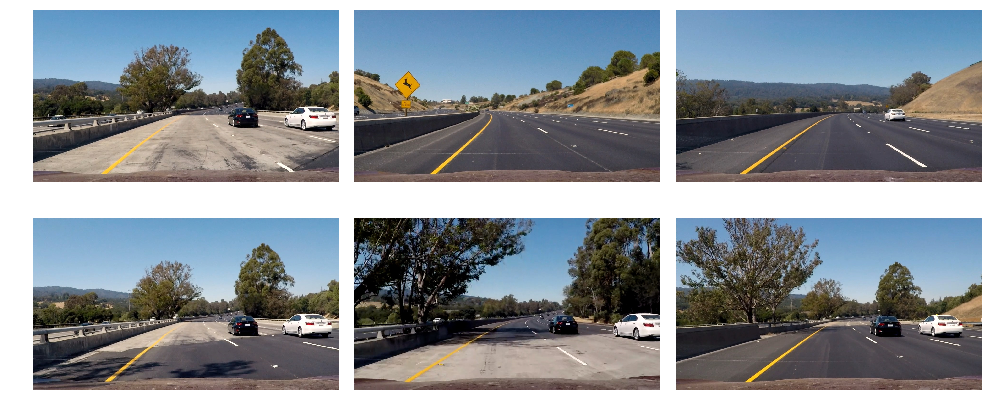

In [19]:
originalImages = []
rgbOriginalImages = []
images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(2,3, figsize=(17, 7))
fig.subplots_adjust(hspace = .2, wspace=.05)
axs = axs.ravel()

for i, fname in enumerate(images):
    
    image = cv2.imread(fname)
    originalImages.append(image)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rgbOriginalImages.append(image)
    
    axs[i].axis('off')
    axs[i].imshow(image)


### Define Windows

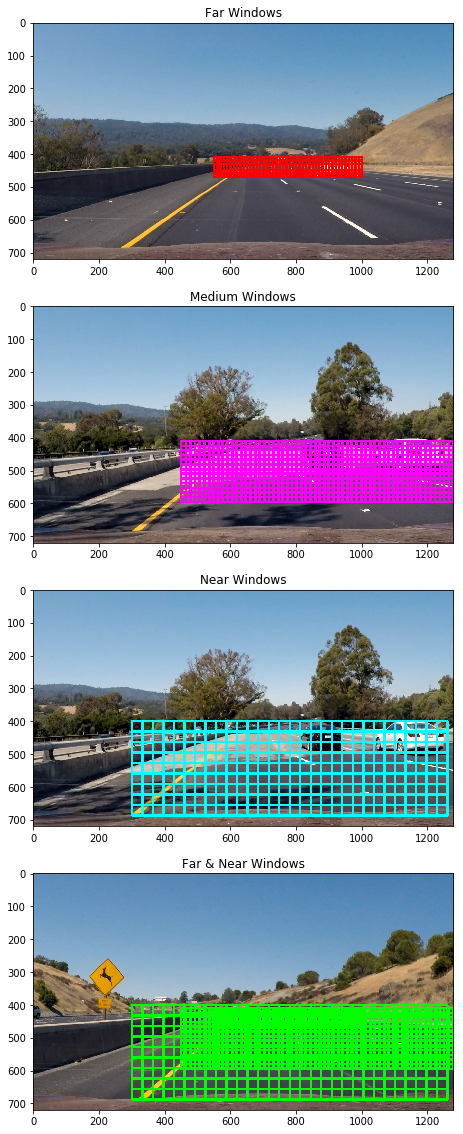

In [20]:
fig, axs = plt.subplots(4, 1, figsize=(17, 20))
fig.subplots_adjust(hspace = .2, wspace=.05)

x_start_stop1 = [550, 1000]
y_start_stop1 = [410, 470]
x_start_stop2 = [450, None]
y_start_stop2 = [410, 600]
x_start_stop3 = [300, None]
y_start_stop3 = [400, 700]

axs = axs.ravel()
image = np.copy(rgbOriginalImages[2])
windows1 = slide_window(image, x_start_stop=x_start_stop1, y_start_stop=y_start_stop1, 
                    xy_window=(40, 40), xy_overlap=(0.75, 0.75))

window_img = draw_boxes(image, windows1, color=(255, 0, 0), thick=6)   

axs[0].imshow(window_img)
axs[0].set_title('Far Windows')

image = np.copy(rgbOriginalImages[3])
windows2 = slide_window(image, x_start_stop=x_start_stop2, y_start_stop=y_start_stop2, 
                    xy_window=(72, 72), xy_overlap=(0.80, 0.80))
                       
window_img2 = draw_boxes(image, windows2, color=(255, 0, 255), thick=6)   

axs[1].imshow(window_img2)
axs[1].set_title('Medium Windows')

image = np.copy(rgbOriginalImages[3])
windows3 = slide_window(image, x_start_stop=x_start_stop3, y_start_stop=y_start_stop3, 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
                       
window_img3 = draw_boxes(image, windows3, color=(0, 255, 255), thick=6)   

axs[2].imshow(window_img3)
axs[2].set_title('Near Windows')

image = np.copy(rgbOriginalImages[1])
windows4 = windows1 + windows2 + windows3
window_img4 = draw_boxes(image, windows4, color=(0, 255, 0), thick=6)

axs[3].imshow(window_img4)
axs[3].set_title('Far & Near Windows')
print()

In [21]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [22]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            #debugLog( "function: search_windows - append " + str(window) )
    #8) Return windows for positive detections
    return on_windows

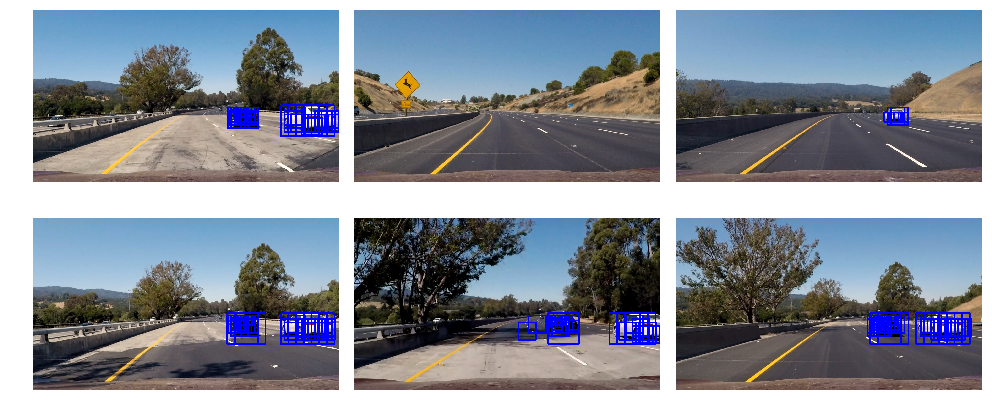

In [23]:
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

fig, axs = plt.subplots(2,3, figsize=(17, 7))
fig.subplots_adjust(hspace = .2, wspace=.05)
axs = axs.ravel()
slideWindowImage = []
slideWindow = []

for i in range(6):

    hot_windows = []
   
    test_Image = np.copy(originalImages[i])
    rgb_image = np.copy(rgbOriginalImages[i])
    
    debugLog( "function: search_windows - image num: " + str(i) )  

    hot_windows = (search_windows(test_Image, windows1, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))           
    
    hot_windows += (search_windows(test_Image, windows2, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))  
    
    hot_windows += (search_windows(test_Image, windows3, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))  

    window_img = draw_boxes(rgb_image, hot_windows, color=(0, 0, 255), thick=6)      
    
    slideWindowImage.append(window_img)
    slideWindow.append(hot_windows)
    
    axs[i].axis('off')
    axs[i].imshow(window_img)
    

### Multiple Detections And False Positives

In [24]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    #debugLog( "function: add_heat" + str(bbox_list) )
    
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [25]:
def apply_threshold(heatmap, threshold):
    
    #debugLog( "function: apply_threshold heatmap: " + str(heatmap)  )
    
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

In [26]:
def draw_labeled_bboxes(img, labels):
    
    debugLog( "function: draw_labeled_bboxes" )
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()        
      
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    # Return the image
    return img

In [27]:
def apply_heatmap(orinalImage, slideWindowImage, slideWindow):
    # Read in a pickle file with bboxes saved
    # Each item in the "all_bboxes" list will contain a 
    # list of boxes for one of the images shown above
    heat = []
    #box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

    heat = np.zeros_like(slideWindowImage[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, slideWindow)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(orinalImage), labels)
    
    return draw_img, heatmap

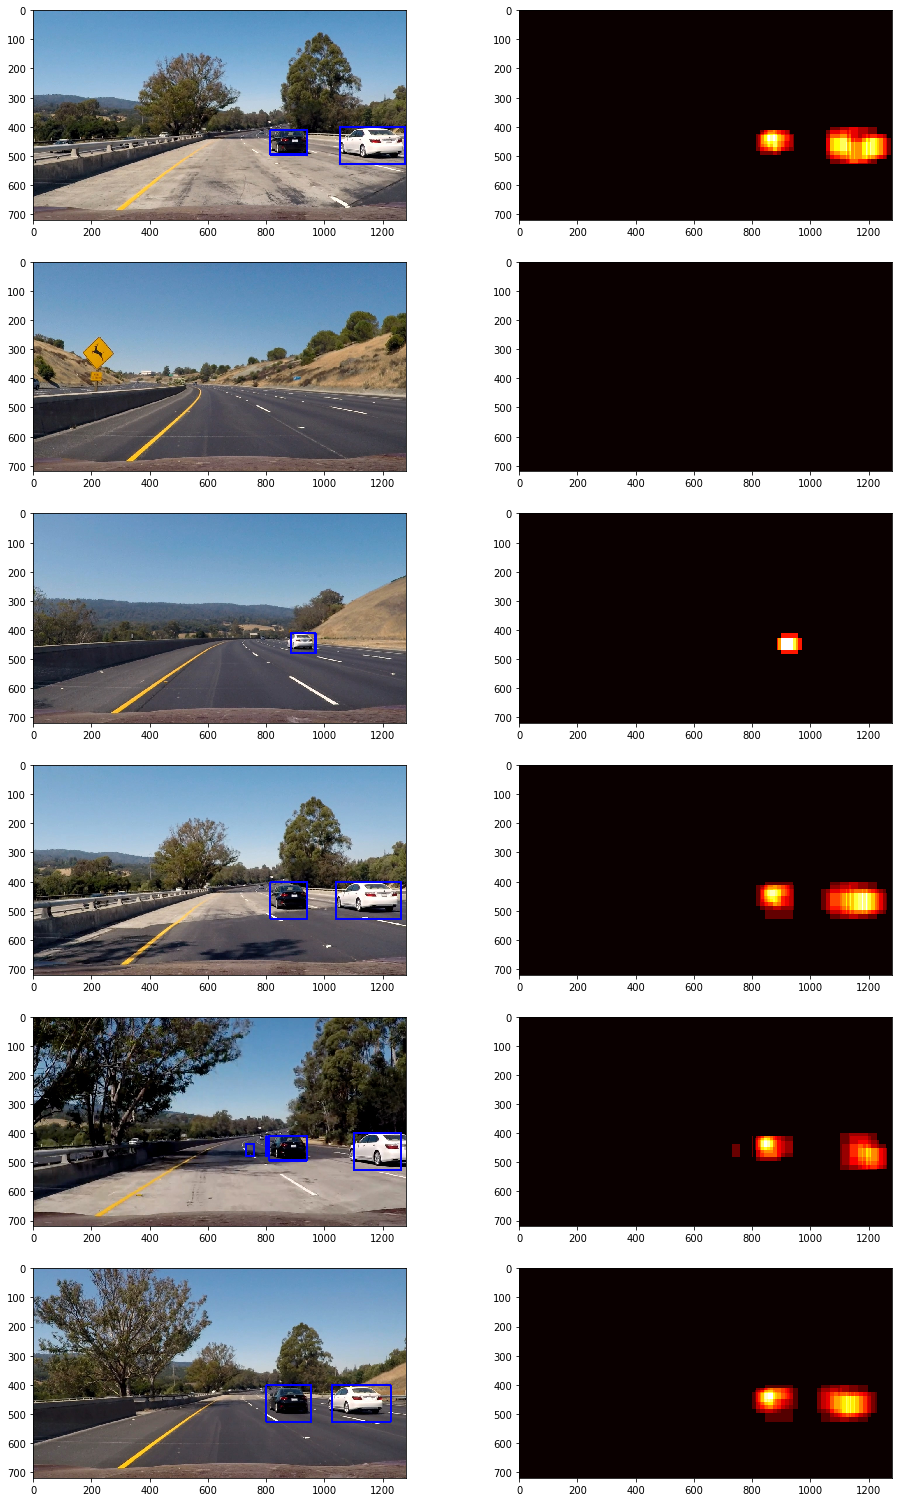

In [28]:
fig, axs = plt.subplots(6,2, figsize=(17, 27))
fig.subplots_adjust(hspace = .2, wspace=.05)
axs = axs.ravel()

j=0
    
for i in range(6):
    img =[]
    heatmap = []    
  
    # debugLog( "function: apply_heatmap - image num: " + str(i) )  
    img, heatmap = apply_heatmap(rgbOriginalImages[i], slideWindowImage[i], slideWindow[i]) 
    
    axs[j].imshow(img)
    j+=1
    axs[j].imshow(heatmap, cmap='hot')
    j+=1


# Pipeline
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

### Load Test Video

In [33]:
from collections import deque
history_heatmap = deque(maxlen = 8)
frame_count = 0
count = 0

color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 16  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True # Histogram features on or off 
hog_feat = True # HOG features on or off


def Vehicle_Dection( image ):
    global count, frame_count
        
    debugLog( "function: Vehicle_Dection " + str(frame_count) )  
    resultImage = np.copy(image)
       
    if (frame_count % 3 == 0) : # Skip every second video frame
    
        heat = []
        slideWindow = []
        
        test_Image = cv2.cvtColor(np.copy(image), cv2.COLOR_BGR2RGB )
        
        slideWindow = (search_windows(test_Image, windows1, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat))           
    
        slideWindow += (search_windows(test_Image, windows2, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat))      

        slideWindow += (search_windows(test_Image, windows3, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)) 

        slideWindowImage = draw_boxes(test_Image, slideWindow, color=(0, 0, 255), thick=6)         
    
        heat = np.zeros_like(slideWindowImage[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        heat = add_heat(heat, slideWindow)
    
        # Apply threshold to help remove false positives            
        heat = apply_threshold(heat, 4 )
    
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)      

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        resultImage = draw_labeled_bboxes(np.copy(image), labels)        
   
    frame_count += 1
    
    return resultImage

In [30]:
def load_test_video(file_name):

    video_out = 'result_' + file_name
    video_input = VideoFileClip(file_name)

    processed_video = video_input.fl_image(Vehicle_Dection)
    %time processed_video.write_videofile(video_out, audio=False)
    
    video_input.reader.close()
    video_input.audio.reader.close_proc()
    return

In [31]:
load_test_video(file_name='test_video.mp4')

[MoviePy] >>>> Building video result_test_video.mp4
[MoviePy] Writing video result_test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:31<00:02,  2.41s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_test_video.mp4 

Wall time: 1min 33s


In [34]:
load_test_video(file_name='project_video.mp4')

[MoviePy] >>>> Building video result_project_video.mp4
[MoviePy] Writing video result_project_video.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:28:11<00:04,  4.18s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_project_video.mp4 

Wall time: 1h 28min 14s
